In [18]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, utils
from dsd import DSDTraining, UpdateMasks
from utils import *

# I/ Dataset

In [20]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
train_x = train_x[..., None] / 255.
test_x = test_x[..., None] / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

print(train_x.shape, test_x.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# II/ Model

In [21]:
class VGG13(tf.keras.Model):
    
    def __init__(self, inputs_shape= (28, 28, 1), is_built_model=False, num_classes=8):
        super(VGG13, self).__init__()

        self.inputs_shape = inputs_shape
        self.num_classes = num_classes
        
        self.conv1 = layers.Conv2D(64, (3, 3), padding="same", activation='relu')
        self.conv2 = layers.Conv2D(64, (3, 3), padding="same", activation='relu')
        self.pool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))
        self.dp1 = layers.Dropout(0.25)
        
        self.conv3 = layers.Conv2D(128, (3, 3), padding="same", activation="relu")
        self.conv4 = layers.Conv2D(128, (3, 3), padding="same", activation="relu") 
        self.pool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))
        self.dp2 = layers.Dropout(0.25)
        
        self.conv5 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")
        self.conv6 = layers.Conv2D(256, (3, 3), padding="same", activation="relu") 
        self.conv7 = layers.Conv2D(256, (3, 3), padding="same", activation="relu") 
        self.pool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))
        self.dp3 = layers.Dropout(0.25)
        
        self.conv8 = layers.Conv2D(256, (3, 3), padding="same", activation="relu")
        self.conv9 = layers.Conv2D(256, (3, 3), padding="same", activation="relu") 
        self.conv10 = layers.Conv2D(256, (3, 3), padding="same", activation="relu") 
        self.pool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(2,2))
        self.dp4 = layers.Dropout(0.25)

        self.dense1 = layers.Dense(1024, activation="relu")
        self.dp5 = layers.Dropout(0.5)
        self.dense2 = layers.Dense(1024, activation="relu")
        self.dp6 = layers.Dropout(0.5)
        self.dense3 = layers.Dense(self.num_classes, activation="softmax")
        
        if is_built_model:
            self.build_model()
        
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dp1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dp2(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = self.dp3(x)
        
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.pool4(x)
        x = self.dp4(x)

        x = layers.Flatten()(x)

        x = self.dense1(x)
        x = self.dp5(x)
        x = self.dense2(x)
        x = self.dp6(x)
        x = self.dense3(x)

        return x

    def build_model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))

In [22]:
tf.random.set_seed(42)
dsd_model = DSDTraining(VGG13(is_built_model=True, num_classes=10), 0.3)
dsd_model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=["accuracy"])

# III/ Train on Dense

In [23]:
dsd_model.fit(train_x, train_y, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 2.3013 - accuracy: 0.1116
Epoch 2/5
1875/1875 [==============================] - 16s 8ms/step - loss: 2.2594 - accuracy: 0.1603
Epoch 3/5
1875/1875 [==============================] - 16s 8ms/step - loss: 1.0307 - accuracy: 0.6389
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3242 - accuracy: 0.9021
Epoch 5/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1929 - accuracy: 0.9436


Percentage of non-zero value conv2d_11: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_12: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_13: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_14: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_15: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_16: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_17: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_18: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_19: w = 100.0 | b = 100.0
Percentage of non-zero value dense_3: w = 100.0 | b = 100.0
Percentage of non-zero value dense_4: w = 100.0 | b = 100.0
Percentage of non-zero value dense_5: w = 100.0 | b = 100.0


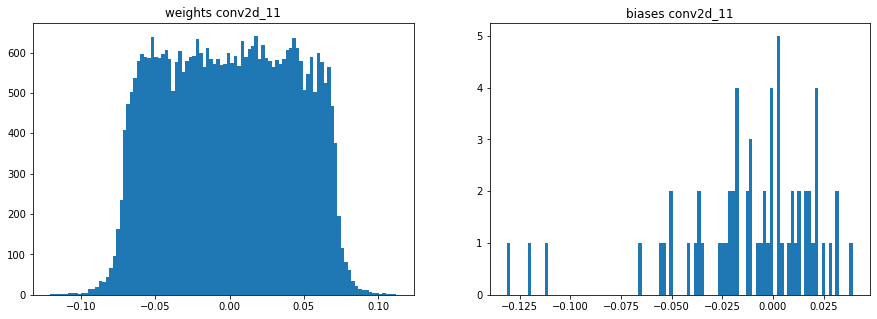

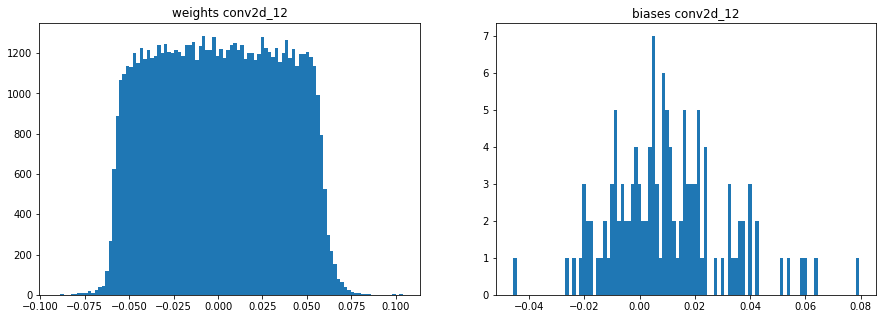

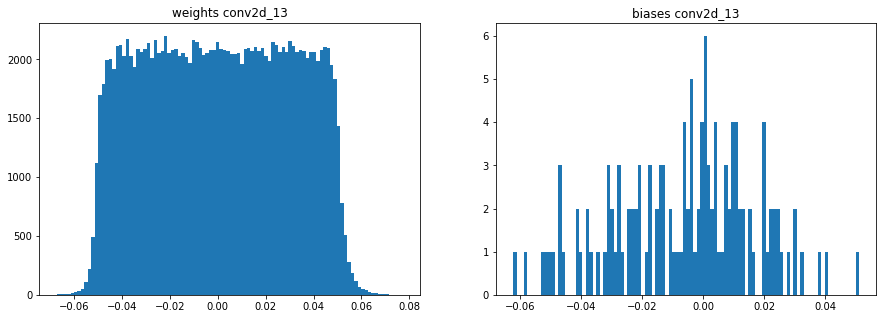

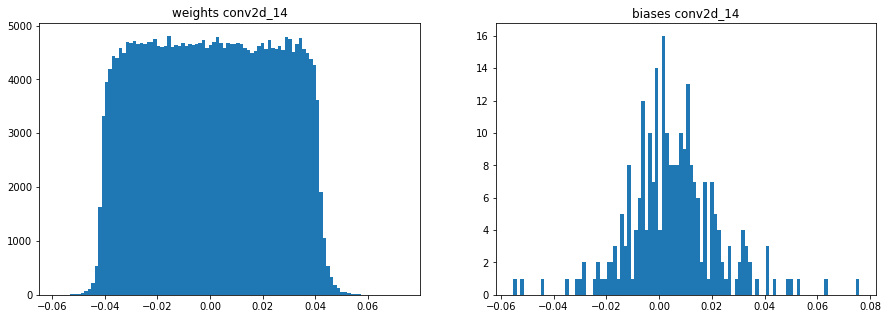

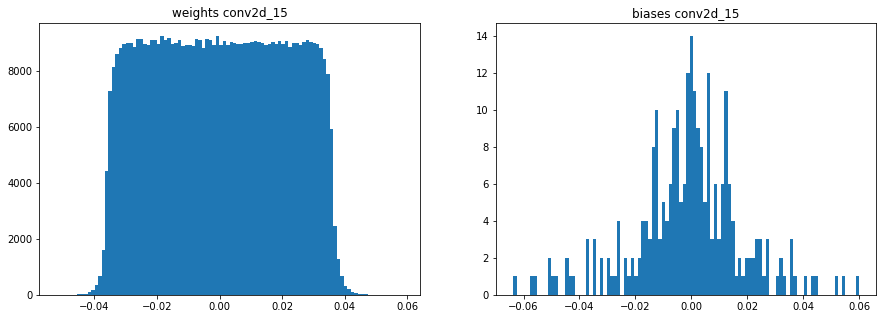

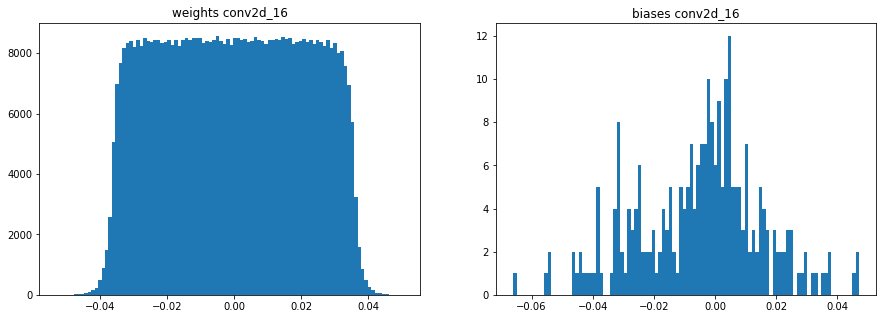

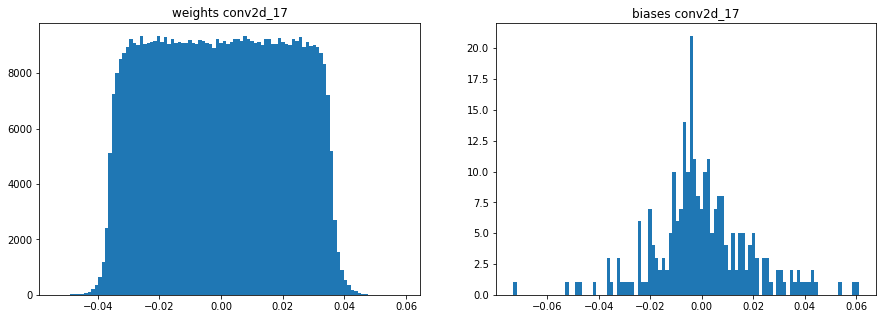

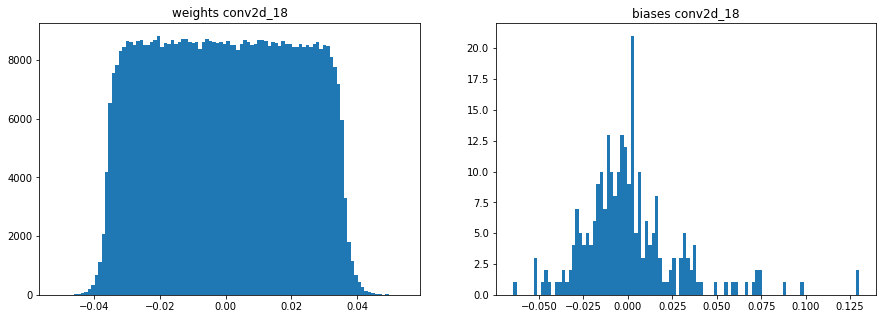

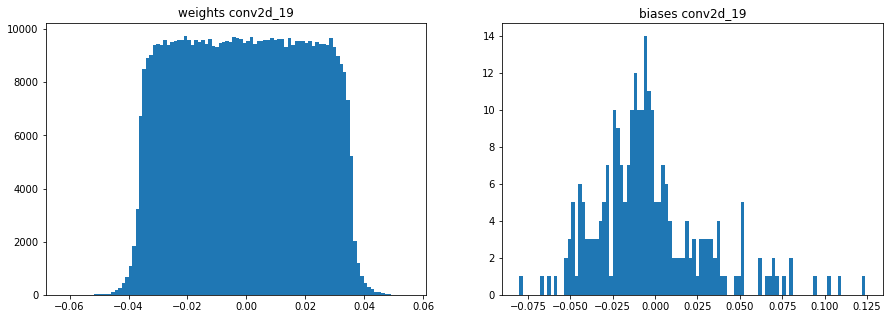

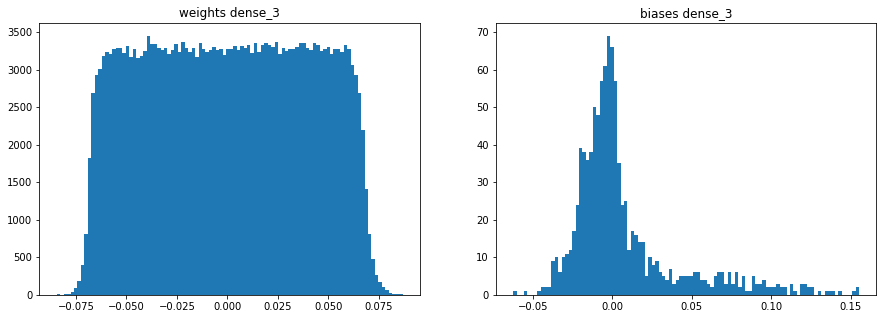

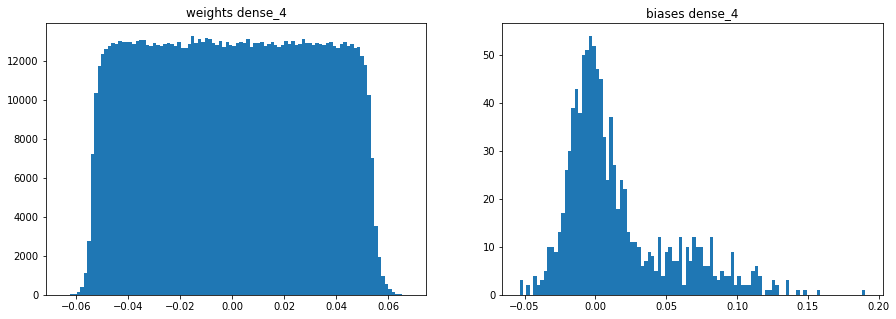

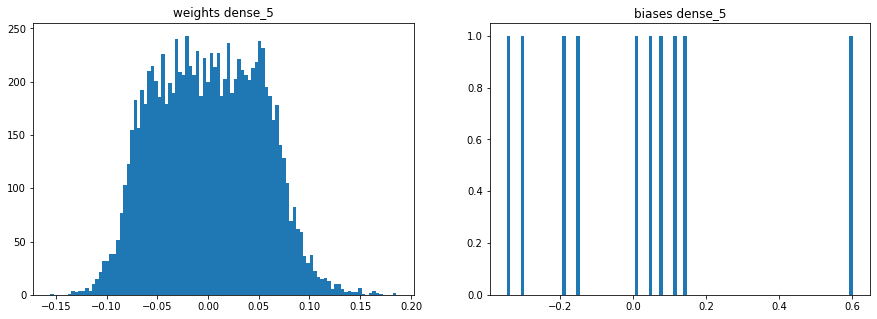

In [25]:
plot_wb(dsd_model.model)
wb_non_zero_percentage(dsd_model.model)

# II/ Train on sparse

In [26]:
dsd_model.train_on_sparse = True
dsd_model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
dsd_model.fit(train_x, train_y, epochs=3, callbacks=[UpdateMasks()])

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1252 - accuracy: 0.9625
Epoch 2/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1007 - accuracy: 0.9698
Epoch 3/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0825 - accuracy: 0.9757


Percentage of non-zero value conv2d_11: w = 70.00054253472221 | b = 70.00054253472221
Percentage of non-zero value conv2d_12: w = 70.00054253472221 | b = 70.00054253472221
Percentage of non-zero value conv2d_13: w = 70.00054253472221 | b = 70.00054253472221
Percentage of non-zero value conv2d_14: w = 70.00020345052084 | b = 70.00020345052084
Percentage of non-zero value conv2d_15: w = 70.00003390842014 | b = 70.00003390842014
Percentage of non-zero value conv2d_16: w = 70.00003390842014 | b = 70.00003390842014
Percentage of non-zero value conv2d_17: w = 70.00003390842014 | b = 70.00003390842014
Percentage of non-zero value conv2d_18: w = 70.00003390842014 | b = 70.00003390842014
Percentage of non-zero value conv2d_19: w = 70.00003390842014 | b = 70.00003390842014
Percentage of non-zero value dense_3: w = 70.00007629394531 | b = 70.00007629394531
Percentage of non-zero value dense_4: w = 70.00007629394531 | b = 70.00007629394531
Percentage of non-zero value dense_5: w = 70.0 | b = 70.0


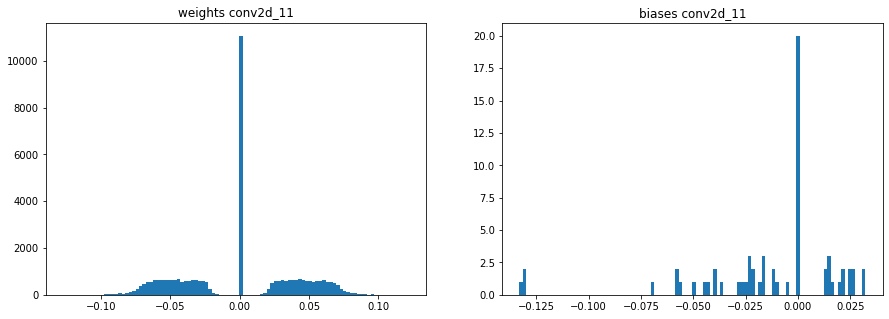

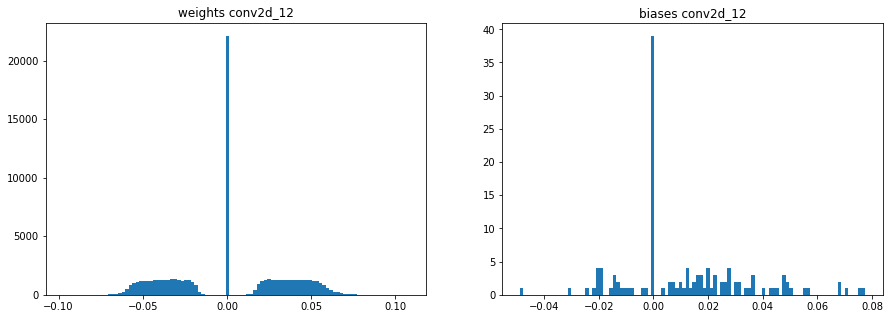

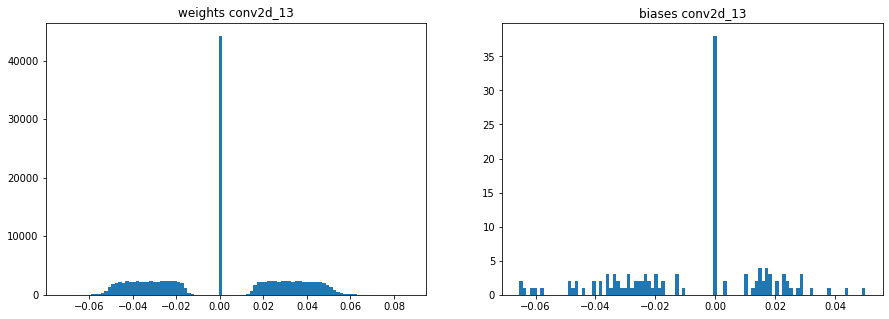

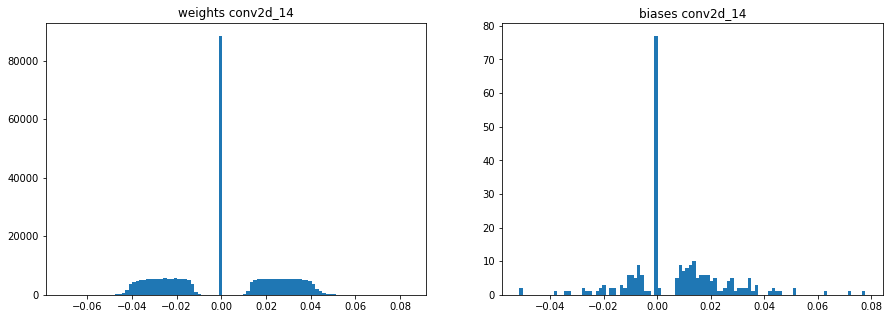

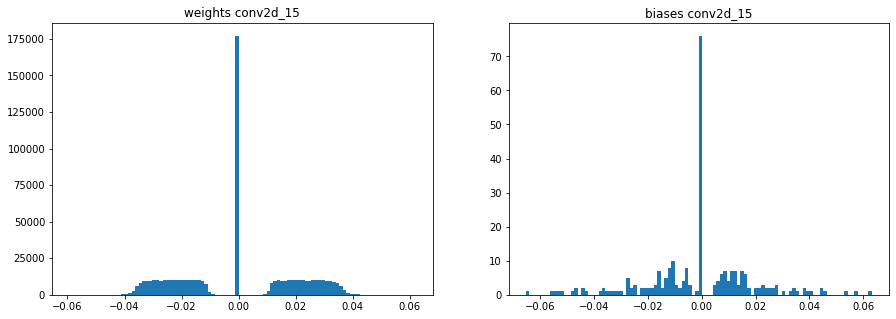

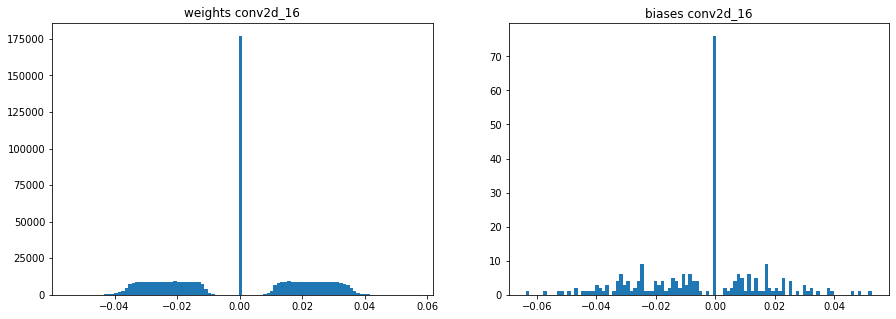

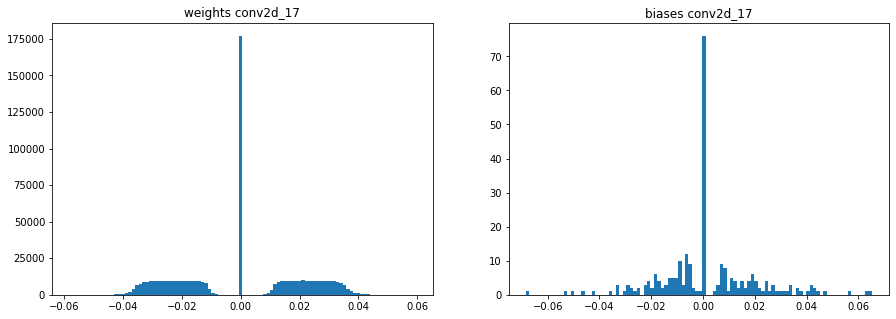

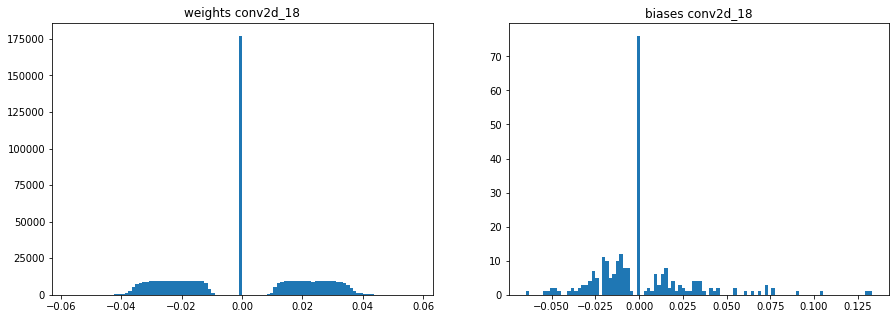

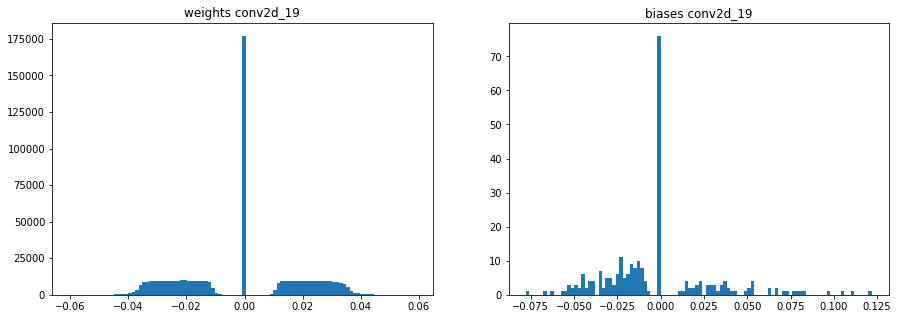

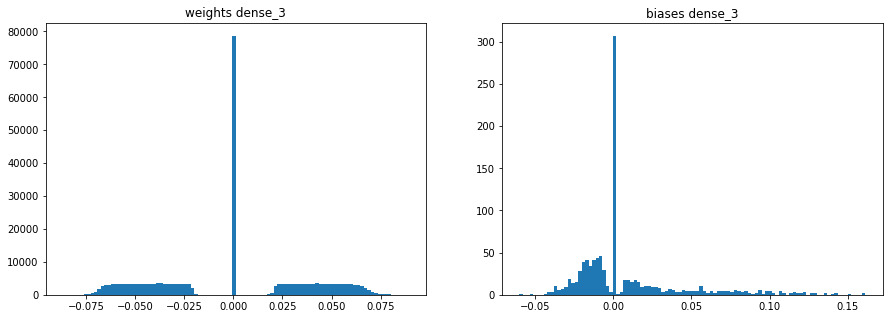

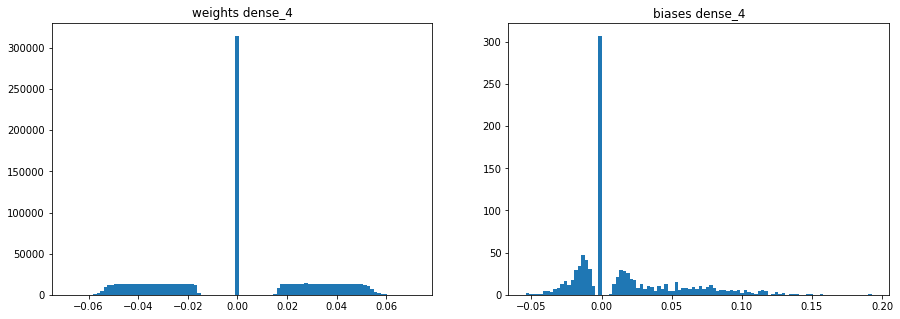

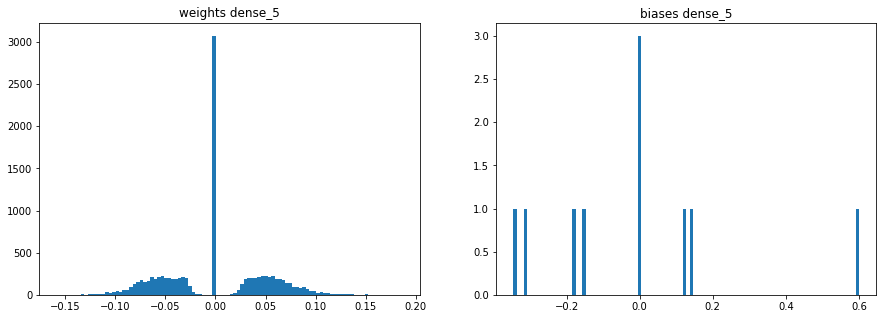

In [28]:
plot_wb(dsd_model.model)
wb_non_zero_percentage(dsd_model.model)

# III/ Train on Dense

In [29]:
dsd_model.train_on_sparse = False
dsd_model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

In [30]:
dsd_model.fit(train_x, train_y, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0661 - accuracy: 0.9811
Epoch 2/2
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0570 - accuracy: 0.9834


Percentage of non-zero value conv2d_11: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_12: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_13: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_14: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_15: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_16: w = 99.99915228949654 | b = 99.99915228949654
Percentage of non-zero value conv2d_17: w = 100.0 | b = 100.0
Percentage of non-zero value conv2d_18: w = 99.99966091579861 | b = 99.99966091579861
Percentage of non-zero value conv2d_19: w = 99.74399142795139 | b = 99.74399142795139
Percentage of non-zero value dense_3: w = 99.99923706054688 | b = 99.99923706054688
Percentage of non-zero value dense_4: w = 100.0 | b = 100.0
Percentage of non-zero value dense_5: w = 100.0 | b = 100.0


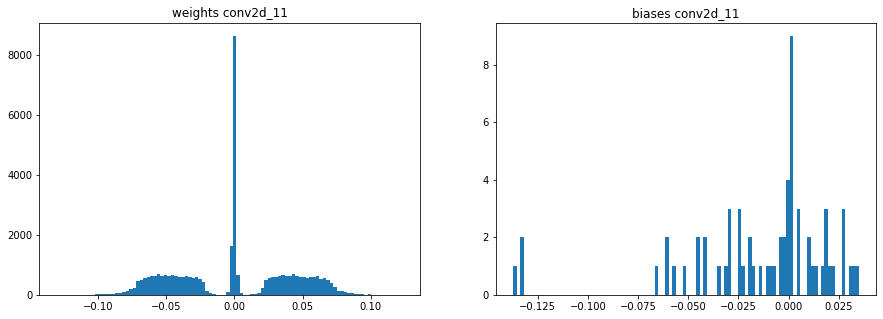

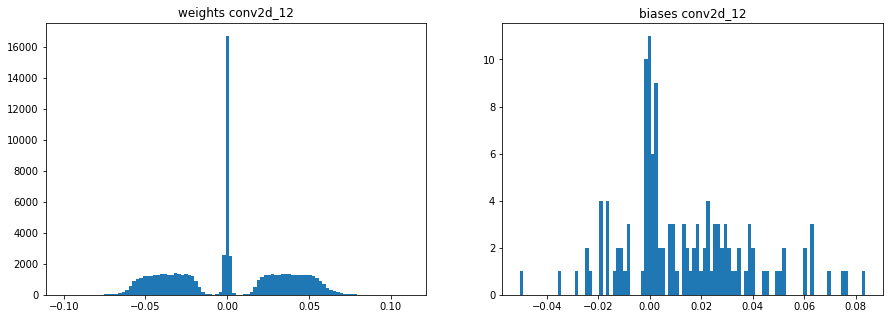

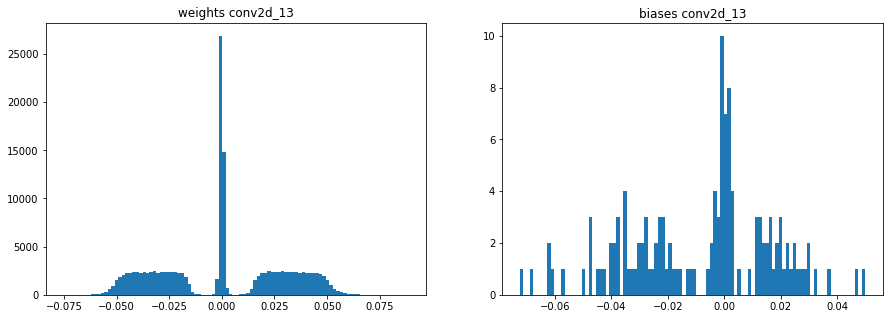

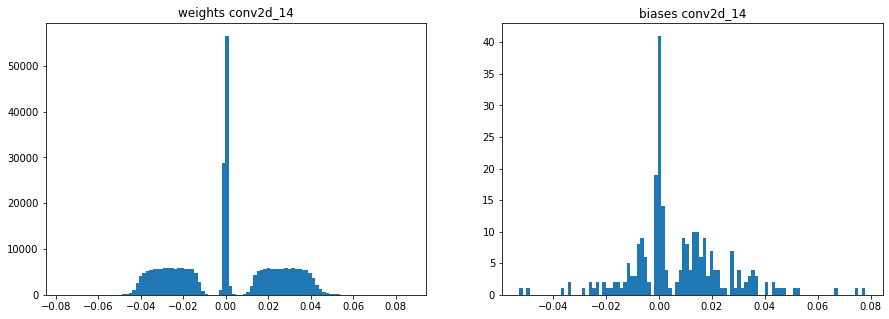

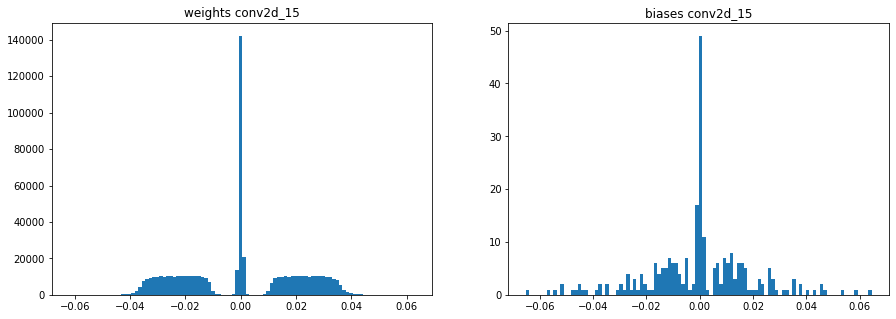

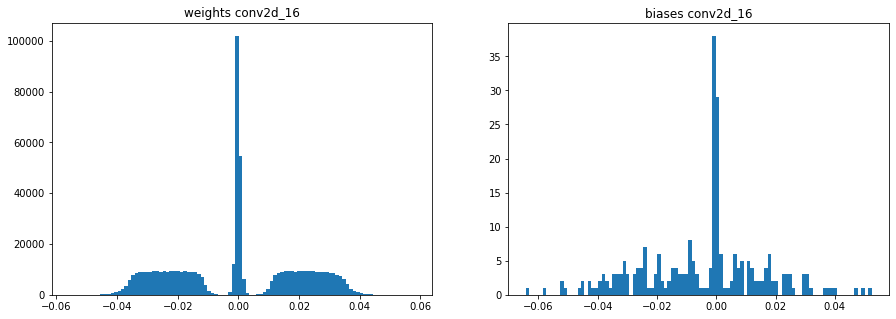

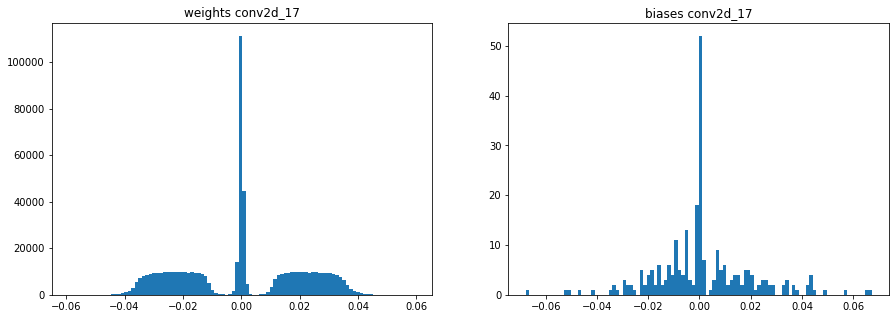

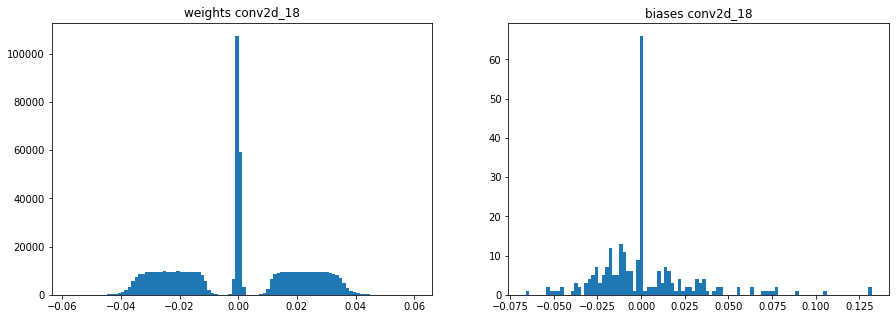

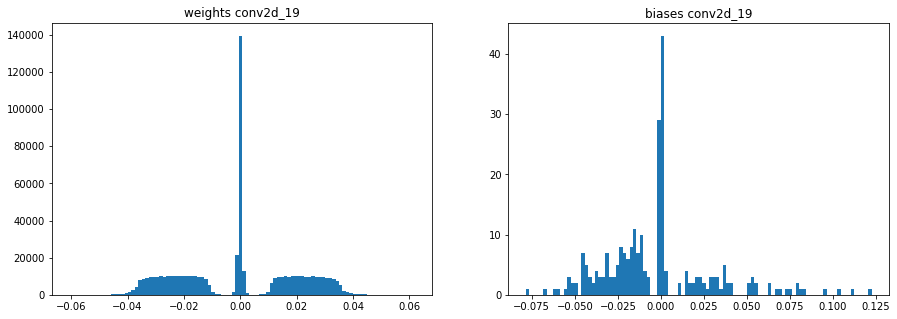

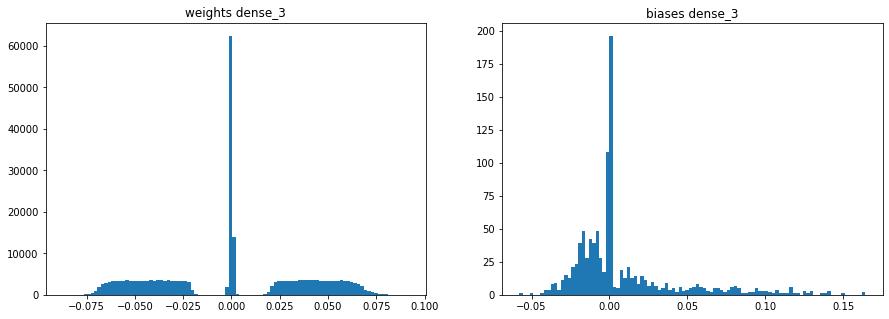

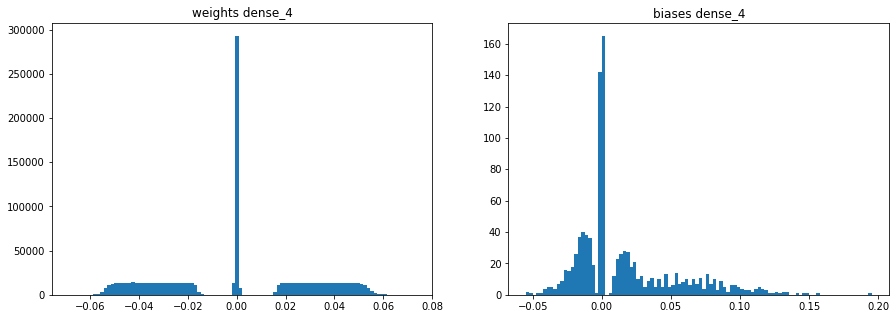

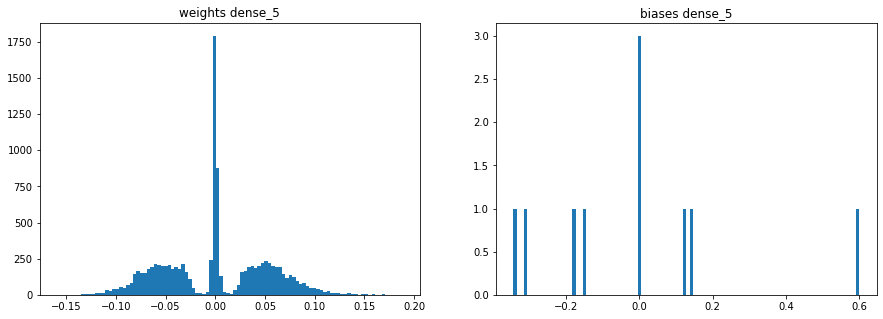

In [31]:
plot_wb(dsd_model.model)
wb_non_zero_percentage(dsd_model.model)